**Load Module**

In [1]:
# Utils
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import os
import torchvision.models as models
from utility.early_stopping import EarlyStopping
# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler


import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from tensorboardX import SummaryWriter

# sklearn
from sklearn.metrics import confusion_matrix, classification_report

**Seed Setting**

In [2]:
random.seed(0)

**Device Setting**

In [3]:
# 디바이스 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Set Hyperparameters**

In [4]:
batch_size = 256
num_epochs = 20
learning_rate = 0.001
momentum = 0.9

# Data Preprocessing

In [5]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Pad(padding=4, fill=0, padding_mode='constant'),  # 이미지 주변에 패딩 추가
    transforms.RandomCrop(32),  # 패딩된 이미지에서 랜덤하게 32x32 크기로 자름
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

**Splitting the training data**

In [6]:
train_data = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
val_data = datasets.CIFAR100(root='./data', train=True, download=True, transform=val_transform)
test_data = datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [7]:
# train 데이터를 train/val로 나누기
num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(0.2 * num_train))  # validation 데이터를 20%로 설정

np.random.shuffle(indices)
train_idx, val_idx = indices[split:], indices[:split]

# train_sampler = SubsetRandomSampler(train_idx)
# val_sampler = SubsetRandomSampler(val_idx)

**Define Dataloader**

In [8]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

**Training Loop**

In [9]:
from models import resnet

print("use:", device)

# 모델 초기화
# net = Net()
net = resnet.resnet18()

# 모델을 GPU로 이동
net.to(device)

print(summary(net, (3,224,224)))

use: cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,728
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,864
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
            Conv2d-7         [-1, 64, 224, 224]          36,864
       BatchNorm2d-8         [-1, 64, 224, 224]             128
        BasicBlock-9         [-1, 64, 224, 224]               0
           Conv2d-10         [-1, 64, 224, 224]          36,864
      BatchNorm2d-11         [-1, 64, 224, 224]             128
             ReLU-12         [-1, 64, 224, 224]               0
           Conv2d-13         [-1, 64, 224, 224]          36,864
      BatchNorm2d-14       

In [10]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]}]


**Model Train**

In [11]:
writer = SummaryWriter("./runs/resnet_18/tensorboard")

In [12]:
early_stopping = EarlyStopping(patience=5, verbose=True)

In [13]:
# 모델 학습 함수
def train_model(model, trainloader, criterion, optimizer, num_epochs=num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (inputs, labels) in enumerate(trainloader):
            labels = labels.type(torch.LongTensor).to(device)  # CPU에서 long type tensor로 변환
            inputs = inputs.to(device)

            optimizer.zero_grad()

            # 모델 예측
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 역전파 및 최적화
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            # 30번째 배치마다 상태 출력
            if (batch_idx + 1) % 30 == 0:
                print(f"Batch [{batch_idx+1}/{len(trainloader)}], Loss: {loss.item():.4f}")

        # Epoch당 평균 손실 계산 및 출력
        epoch_loss = running_loss / len(trainloader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

        # Early Stopping 체크
        early_stopping(epoch_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

**Model Test**

In [14]:
# 모델 평가 및 테스트 함수 (superclass 예측 포함)
def test_model(model, val_loader, criterion, epoch):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # 모델 예측
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item() * inputs.size(0)

            # 예측 결과 저장 및 정확도 계산
            pred = outputs.argmax(dim=1)
            correct += (pred == labels).sum().item()

            # TensorBoard에 테스트 손실 및 정확도 기록
            writer.add_scalar("Test Loss", test_loss / len(val_loader.dataset), epoch)
            writer.add_scalar("Test Accuracy", correct / len(val_loader.dataset), epoch)

    # 평균 손실 및 정확도 계산
    test_loss /= len(val_loader.dataset)
    accuracy = correct / len(val_loader.dataset)
    # test_accuracies.append(accuracy)

    return test_loss, accuracy

**Per-Epoch Training**

In [15]:
for epoch in tqdm(range(1, num_epochs + 1)):
    train_model(net, train_loader, criterion, optimizer, num_epochs=num_epochs)
    test_loss, test_accuracy = test_model(net, val_loader, criterion, epoch)
    writer.add_scalar("Test Loss", test_loss, num_epochs)
    writer.add_scalar("Test Accuracy", test_accuracy, num_epochs)
    print(f"Processing Result = Epoch : {epoch}   Loss : {test_loss}   Accuracy : {test_accuracy}")
    writer.close()

  0%|                                                    | 0/20 [00:00<?, ?it/s]

Batch [30/196], Loss: 4.5102
Batch [60/196], Loss: 4.2969
Batch [90/196], Loss: 4.2472
Batch [120/196], Loss: 4.1294
Batch [150/196], Loss: 4.0910
Batch [180/196], Loss: 3.9162
Epoch [1/20], Loss: 4.2344
Validation loss decreased (inf --> 4.234444).  Saving model ...
Batch [30/196], Loss: 3.8212
Batch [60/196], Loss: 3.8365
Batch [90/196], Loss: 3.6646
Batch [120/196], Loss: 3.7301
Batch [150/196], Loss: 3.6059
Batch [180/196], Loss: 3.5110
Epoch [2/20], Loss: 3.7500
Validation loss decreased (4.234444 --> 3.749983).  Saving model ...
Batch [30/196], Loss: 3.5271
Batch [60/196], Loss: 3.5468
Batch [90/196], Loss: 3.6740
Batch [120/196], Loss: 3.4559
Batch [150/196], Loss: 3.7211
Batch [180/196], Loss: 3.5280
Epoch [3/20], Loss: 3.5141
Validation loss decreased (3.749983 --> 3.514062).  Saving model ...
Batch [30/196], Loss: 3.2276
Batch [60/196], Loss: 3.4342
Batch [90/196], Loss: 3.3165
Batch [120/196], Loss: 3.4501
Batch [150/196], Loss: 3.2505
Batch [180/196], Loss: 3.2075
Epoch [4/

  5%|██                                       | 1/20 [03:57<1:15:14, 237.58s/it]

Processing Result = Epoch : 1   Loss : 1.6323607662963868   Accuracy : 0.54292
Batch [30/196], Loss: 1.5931
Batch [60/196], Loss: 1.4743
Batch [90/196], Loss: 1.5675
Batch [120/196], Loss: 1.6488
Batch [150/196], Loss: 1.5144
Batch [180/196], Loss: 1.6499
Epoch [1/20], Loss: 1.6113
Validation loss decreased (1.667804 --> 1.611318).  Saving model ...
Batch [30/196], Loss: 1.4997
Batch [60/196], Loss: 1.5116
Batch [90/196], Loss: 1.7622
Batch [120/196], Loss: 1.6702
Batch [150/196], Loss: 1.4873
Batch [180/196], Loss: 1.6184
Epoch [2/20], Loss: 1.5559
Validation loss decreased (1.611318 --> 1.555904).  Saving model ...
Batch [30/196], Loss: 1.4786
Batch [60/196], Loss: 1.5483
Batch [90/196], Loss: 1.6069
Batch [120/196], Loss: 1.4699
Batch [150/196], Loss: 1.5595
Batch [180/196], Loss: 1.4275
Epoch [3/20], Loss: 1.5070
Validation loss decreased (1.555904 --> 1.507025).  Saving model ...
Batch [30/196], Loss: 1.5084
Batch [60/196], Loss: 1.4038
Batch [90/196], Loss: 1.4530
Batch [120/196]

 10%|████                                     | 2/20 [09:00<1:22:43, 275.75s/it]

Processing Result = Epoch : 2   Loss : 0.848866988773346   Accuracy : 0.74448
Batch [30/196], Loss: 0.9026
Batch [60/196], Loss: 0.8054
Batch [90/196], Loss: 0.9521
Batch [120/196], Loss: 0.8772
Batch [150/196], Loss: 0.8259
Batch [180/196], Loss: 0.9631
Epoch [1/20], Loss: 0.8623
Validation loss decreased (0.888890 --> 0.862321).  Saving model ...
Batch [30/196], Loss: 0.8500
Batch [60/196], Loss: 0.7619
Batch [90/196], Loss: 0.8773
Batch [120/196], Loss: 0.7986
Batch [150/196], Loss: 0.7770
Batch [180/196], Loss: 0.8572
Epoch [2/20], Loss: 0.8357
Validation loss decreased (0.862321 --> 0.835689).  Saving model ...
Batch [30/196], Loss: 0.7435
Batch [60/196], Loss: 0.8344
Batch [90/196], Loss: 0.7120
Batch [120/196], Loss: 0.7547
Batch [150/196], Loss: 0.7961
Batch [180/196], Loss: 0.7607
Epoch [3/20], Loss: 0.8090
Validation loss decreased (0.835689 --> 0.809011).  Saving model ...
Batch [30/196], Loss: 0.8405
Batch [60/196], Loss: 0.8651
Batch [90/196], Loss: 0.8913
Batch [120/196],

 15%|██████▏                                  | 3/20 [14:56<1:28:37, 312.77s/it]

Processing Result = Epoch : 3   Loss : 0.39488859738349913   Accuracy : 0.87726
Batch [30/196], Loss: 0.3741
Batch [60/196], Loss: 0.4989
Batch [90/196], Loss: 0.3739
Batch [120/196], Loss: 0.3143
Batch [150/196], Loss: 0.3903
Batch [180/196], Loss: 0.4484
Epoch [1/20], Loss: 0.4107
Validation loss decreased (0.432800 --> 0.410712).  Saving model ...
Batch [30/196], Loss: 0.2942
Batch [60/196], Loss: 0.3653
Batch [90/196], Loss: 0.4356
Batch [120/196], Loss: 0.3932
Batch [150/196], Loss: 0.3251
Batch [180/196], Loss: 0.3535
Epoch [2/20], Loss: 0.3924
Validation loss decreased (0.410712 --> 0.392353).  Saving model ...
Batch [30/196], Loss: 0.3705
Batch [60/196], Loss: 0.4260
Batch [90/196], Loss: 0.3819
Batch [120/196], Loss: 0.4120
Batch [150/196], Loss: 0.3443
Batch [180/196], Loss: 0.5025
Epoch [3/20], Loss: 0.3772
Validation loss decreased (0.392353 --> 0.377241).  Saving model ...
Batch [30/196], Loss: 0.3169
Batch [60/196], Loss: 0.4022
Batch [90/196], Loss: 0.3357
Batch [120/196

 20%|████████▏                                | 4/20 [20:40<1:26:37, 324.85s/it]

Processing Result = Epoch : 4   Loss : 0.14437386479377748   Accuracy : 0.96068
Batch [30/196], Loss: 0.1558
Batch [60/196], Loss: 0.1896
Batch [90/196], Loss: 0.1486
Batch [120/196], Loss: 0.1629
Batch [150/196], Loss: 0.1691
Batch [180/196], Loss: 0.1197
Epoch [1/20], Loss: 0.1685
Validation loss decreased (0.174982 --> 0.168542).  Saving model ...
Batch [30/196], Loss: 0.1436
Batch [60/196], Loss: 0.1403
Batch [90/196], Loss: 0.1556
Batch [120/196], Loss: 0.1771
Batch [150/196], Loss: 0.1706
Batch [180/196], Loss: 0.1721
Epoch [2/20], Loss: 0.1580
Validation loss decreased (0.168542 --> 0.158012).  Saving model ...
Batch [30/196], Loss: 0.0998
Batch [60/196], Loss: 0.1574
Batch [90/196], Loss: 0.1624
Batch [120/196], Loss: 0.1846
Batch [150/196], Loss: 0.1439
Batch [180/196], Loss: 0.1313
Epoch [3/20], Loss: 0.1520
Validation loss decreased (0.158012 --> 0.152006).  Saving model ...
Batch [30/196], Loss: 0.1331
Batch [60/196], Loss: 0.1461
Batch [90/196], Loss: 0.1133
Batch [120/196

 25%|██████████▎                              | 5/20 [26:40<1:24:23, 337.54s/it]

Processing Result = Epoch : 5   Loss : 0.05415507138490677   Accuracy : 0.9884
Batch [30/196], Loss: 0.0912
Batch [60/196], Loss: 0.0567
Batch [90/196], Loss: 0.0651
Batch [120/196], Loss: 0.0622
Batch [150/196], Loss: 0.0704
Batch [180/196], Loss: 0.0657
Epoch [1/20], Loss: 0.0698
Validation loss decreased (0.072770 --> 0.069788).  Saving model ...
Batch [30/196], Loss: 0.0687
Batch [60/196], Loss: 0.0497
Batch [90/196], Loss: 0.0499
Batch [120/196], Loss: 0.0655
Batch [150/196], Loss: 0.0764
Batch [180/196], Loss: 0.0708
Epoch [2/20], Loss: 0.0691
Validation loss decreased (0.069788 --> 0.069064).  Saving model ...
Batch [30/196], Loss: 0.0624
Batch [60/196], Loss: 0.0707
Batch [90/196], Loss: 0.0708
Batch [120/196], Loss: 0.0773
Batch [150/196], Loss: 0.0639
Batch [180/196], Loss: 0.0743
Epoch [3/20], Loss: 0.0682
Validation loss decreased (0.069064 --> 0.068250).  Saving model ...
Batch [30/196], Loss: 0.0673
Batch [60/196], Loss: 0.0722
Batch [90/196], Loss: 0.0691
Batch [120/196]

 30%|████████████▎                            | 6/20 [32:21<1:19:02, 338.71s/it]

Processing Result = Epoch : 6   Loss : 0.026135736879706384   Accuracy : 0.99566
Batch [30/196], Loss: 0.0243
Batch [60/196], Loss: 0.0371
Batch [90/196], Loss: 0.0309
Batch [120/196], Loss: 0.0429
Batch [150/196], Loss: 0.0303
Batch [180/196], Loss: 0.0232
Epoch [1/20], Loss: 0.0354
Validation loss decreased (0.037271 --> 0.035354).  Saving model ...
Batch [30/196], Loss: 0.0338
Batch [60/196], Loss: 0.0282
Batch [90/196], Loss: 0.0350
Batch [120/196], Loss: 0.0334
Batch [150/196], Loss: 0.0410
Batch [180/196], Loss: 0.0249
Epoch [2/20], Loss: 0.0359
EarlyStopping counter: 1 out of 5
Batch [30/196], Loss: 0.0302
Batch [60/196], Loss: 0.0306
Batch [90/196], Loss: 0.0264
Batch [120/196], Loss: 0.0261
Batch [150/196], Loss: 0.0442
Batch [180/196], Loss: 0.0362
Epoch [3/20], Loss: 0.0339
Validation loss decreased (0.035354 --> 0.033887).  Saving model ...
Batch [30/196], Loss: 0.0255
Batch [60/196], Loss: 0.0365
Batch [90/196], Loss: 0.0191
Batch [120/196], Loss: 0.0322
Batch [150/196], L

 35%|██████████████▎                          | 7/20 [38:06<1:13:50, 340.80s/it]

Processing Result = Epoch : 7   Loss : 0.014034295496940612   Accuracy : 0.9986
Batch [30/196], Loss: 0.0286
Batch [60/196], Loss: 0.0314
Batch [90/196], Loss: 0.0337
Batch [120/196], Loss: 0.0377
Batch [150/196], Loss: 0.0210
Batch [180/196], Loss: 0.0242
Epoch [1/20], Loss: 0.0261
EarlyStopping counter: 2 out of 5
Batch [30/196], Loss: 0.0165
Batch [60/196], Loss: 0.0267
Batch [90/196], Loss: 0.0404
Batch [120/196], Loss: 0.0295
Batch [150/196], Loss: 0.0232
Batch [180/196], Loss: 0.0204
Epoch [2/20], Loss: 0.0294
EarlyStopping counter: 3 out of 5
Batch [30/196], Loss: 0.0186
Batch [60/196], Loss: 0.0291
Batch [90/196], Loss: 0.0146
Batch [120/196], Loss: 0.0193
Batch [150/196], Loss: 0.0111
Batch [180/196], Loss: 0.0184
Epoch [3/20], Loss: 0.0213
EarlyStopping counter: 4 out of 5
Batch [30/196], Loss: 0.0196
Batch [60/196], Loss: 0.0181
Batch [90/196], Loss: 0.0149
Batch [120/196], Loss: 0.0237
Batch [150/196], Loss: 0.0190
Batch [180/196], Loss: 0.0185
Epoch [4/20], Loss: 0.0203
Va

 40%|████████████████▍                        | 8/20 [43:34<1:07:19, 336.63s/it]

Processing Result = Epoch : 8   Loss : 0.00962631773456931   Accuracy : 0.99894
Batch [30/196], Loss: 0.0090
Batch [60/196], Loss: 0.0377
Batch [90/196], Loss: 0.0151
Batch [120/196], Loss: 0.0177
Batch [150/196], Loss: 0.0127
Batch [180/196], Loss: 0.0153
Epoch [1/20], Loss: 0.0154
Validation loss decreased (0.016435 --> 0.015388).  Saving model ...
Early stopping


 45%|███████████████████▎                       | 9/20 [43:57<43:45, 238.68s/it]

Processing Result = Epoch : 9   Loss : 0.011854767602086067   Accuracy : 0.99836
Batch [30/196], Loss: 0.0314
Batch [60/196], Loss: 0.0113
Batch [90/196], Loss: 0.0162
Batch [120/196], Loss: 0.0170
Batch [150/196], Loss: 0.0148
Batch [180/196], Loss: 0.0136
Epoch [1/20], Loss: 0.0165
EarlyStopping counter: 1 out of 5
Early stopping


 50%|█████████████████████                     | 10/20 [44:19<28:39, 171.97s/it]

Processing Result = Epoch : 10   Loss : 0.013544325302243233   Accuracy : 0.99772
Batch [30/196], Loss: 0.0128
Batch [60/196], Loss: 0.0152
Batch [90/196], Loss: 0.0208
Batch [120/196], Loss: 0.0222
Batch [150/196], Loss: 0.0087
Batch [180/196], Loss: 0.0132
Epoch [1/20], Loss: 0.0150
Validation loss decreased (0.015388 --> 0.014953).  Saving model ...
Early stopping


 55%|███████████████████████                   | 11/20 [44:43<18:57, 126.42s/it]

Processing Result = Epoch : 11   Loss : 0.008313766068816186   Accuracy : 0.99922
Batch [30/196], Loss: 0.0083
Batch [60/196], Loss: 0.0162
Batch [90/196], Loss: 0.0132
Batch [120/196], Loss: 0.0060
Batch [150/196], Loss: 0.0070
Batch [180/196], Loss: 0.0083
Epoch [1/20], Loss: 0.0124
Validation loss decreased (0.014953 --> 0.012408).  Saving model ...
Early stopping


 60%|█████████████████████████▊                 | 12/20 [45:05<12:39, 94.90s/it]

Processing Result = Epoch : 12   Loss : 0.007399324301481247   Accuracy : 0.99936
Batch [30/196], Loss: 0.0168
Batch [60/196], Loss: 0.0086
Batch [90/196], Loss: 0.0109
Batch [120/196], Loss: 0.0085
Batch [150/196], Loss: 0.0190
Batch [180/196], Loss: 0.0276
Epoch [1/20], Loss: 0.0136
EarlyStopping counter: 1 out of 5
Early stopping


 65%|███████████████████████████▉               | 13/20 [45:28<08:31, 73.10s/it]

Processing Result = Epoch : 13   Loss : 0.008651020302772521   Accuracy : 0.9991
Batch [30/196], Loss: 0.0117
Batch [60/196], Loss: 0.0221
Batch [90/196], Loss: 0.0068
Batch [120/196], Loss: 0.0169
Batch [150/196], Loss: 0.0080
Batch [180/196], Loss: 0.0077
Epoch [1/20], Loss: 0.0125
EarlyStopping counter: 2 out of 5
Early stopping


 70%|██████████████████████████████             | 14/20 [45:51<05:47, 57.96s/it]

Processing Result = Epoch : 14   Loss : 0.008087472465634345   Accuracy : 0.99908
Batch [30/196], Loss: 0.0140
Batch [60/196], Loss: 0.0152
Batch [90/196], Loss: 0.0161
Batch [120/196], Loss: 0.0152
Batch [150/196], Loss: 0.0086
Batch [180/196], Loss: 0.0124
Epoch [1/20], Loss: 0.0152
EarlyStopping counter: 3 out of 5
Early stopping


 75%|████████████████████████████████▎          | 15/20 [46:15<03:57, 47.59s/it]

Processing Result = Epoch : 15   Loss : 0.01072002696454525   Accuracy : 0.99878
Batch [30/196], Loss: 0.0122
Batch [60/196], Loss: 0.0108
Batch [90/196], Loss: 0.0189
Batch [120/196], Loss: 0.0129
Batch [150/196], Loss: 0.0112
Batch [180/196], Loss: 0.0079
Epoch [1/20], Loss: 0.0137
EarlyStopping counter: 4 out of 5
Early stopping


 80%|██████████████████████████████████▍        | 16/20 [46:38<02:41, 40.26s/it]

Processing Result = Epoch : 16   Loss : 0.008821658847928047   Accuracy : 0.9992
Batch [30/196], Loss: 0.0072
Batch [60/196], Loss: 0.0085
Batch [90/196], Loss: 0.0090
Batch [120/196], Loss: 0.0197
Batch [150/196], Loss: 0.0160
Batch [180/196], Loss: 0.0074
Epoch [1/20], Loss: 0.0138
EarlyStopping counter: 5 out of 5
Early stopping


 85%|████████████████████████████████████▌      | 17/20 [47:01<01:44, 34.92s/it]

Processing Result = Epoch : 17   Loss : 0.008154471305310726   Accuracy : 0.99914
Batch [30/196], Loss: 0.0081
Batch [60/196], Loss: 0.0107
Batch [90/196], Loss: 0.0104
Batch [120/196], Loss: 0.0159
Batch [150/196], Loss: 0.0088
Batch [180/196], Loss: 0.0206
Epoch [1/20], Loss: 0.0130
EarlyStopping counter: 6 out of 5
Early stopping


 90%|██████████████████████████████████████▋    | 18/20 [47:24<01:02, 31.38s/it]

Processing Result = Epoch : 18   Loss : 0.008943166551887989   Accuracy : 0.9991
Batch [30/196], Loss: 0.0106
Batch [60/196], Loss: 0.0113
Batch [90/196], Loss: 0.0069
Batch [120/196], Loss: 0.0166
Batch [150/196], Loss: 0.0103
Batch [180/196], Loss: 0.0193
Epoch [1/20], Loss: 0.0133
EarlyStopping counter: 7 out of 5
Early stopping


 95%|████████████████████████████████████████▊  | 19/20 [47:47<00:28, 28.91s/it]

Processing Result = Epoch : 19   Loss : 0.007890819859802722   Accuracy : 0.99916
Batch [30/196], Loss: 0.0091
Batch [60/196], Loss: 0.0126
Batch [90/196], Loss: 0.0073
Batch [120/196], Loss: 0.0154
Batch [150/196], Loss: 0.0113
Batch [180/196], Loss: 0.0148
Epoch [1/20], Loss: 0.0127
EarlyStopping counter: 8 out of 5
Early stopping


100%|██████████████████████████████████████████| 20/20 [48:10<00:00, 144.52s/it]

Processing Result = Epoch : 20   Loss : 0.008914991233497859   Accuracy : 0.99896


**Validation Loss Result**

In [30]:
print(f" Result of ResNet = Epoch : {epoch}   Loss : {test_loss}   Accuracy : {test_accuracy}")

 Result of ResNet = Epoch : 5   Loss : 1.3295546631622315   Accuracy : 0.61884


In [31]:
# torch.save(net, "resnet_18.pt")

**Test**

In [32]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('10000개 테스트 이미지에서 모델 정확도: %.2f %%' % (
    100 * correct / total))

10000개 테스트 이미지에서 모델 정확도: 53.14 %


**Visualization of average loss**

In [34]:
# train_accuracies = []
# test_accuracies = []

# # 정확도 시각화
# plt.figure(figsize=(10, 5))
# plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
# plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Train vs Test Accuracy per Epoch')
# plt.legend()
# plt.grid(True)
# plt.show()

**Top-1 Accuracy**

In [35]:
def calculate_top1_accuracy(model, device, data_loader, criterion):
    model.eval()  # 모델을 평가 모드로 설정
    correct = 0
    total = 0
    
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            # # 각 샘플에 대한 예측 결과와 실제 레이블 출력
            # for i in range(data.size(0)):
            #     print(f"Sample {i + 1}: Predicted = {predicted[i].item()}, Actual = {target[i].item()}")

    top1_accuracy = 100 * correct / total
    print(f"Top-1 Accuracy: {top1_accuracy:.2f}%")

In [48]:
# 모델 훈련 후 검증 데이터셋에 대한 Top-1 정확도 계산 및 출력
calculate_top1_accuracy(net, device, val_loader, criterion)

Top-1 Accuracy: 61.88%


**Top-5 Accuracy**

In [37]:
def calculate_and_print_top5_accuracy(model, device, data_loader, criterion):
    model.eval()  # 모델을 평가 모드로 설정
    correct = 0
    total = 0
    
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            # Top-5 예측 결과 가져오기
            _, predicted_top5 = torch.topk(outputs, 5, dim=1)
            total += target.size(0)
            
            # 예측된 Top-5 내에 실제 레이블이 있는지 확인
            correct += (predicted_top5 == target.view(-1, 1)).sum().item()

    top5_accuracy = 100 * correct / total
    print(f"Top-5 Accuracy: {top5_accuracy:.2f}%")

In [49]:
calculate_and_print_top5_accuracy(net, device, val_loader, criterion)

Top-5 Accuracy: 88.75%


**Super Class Accuracy**

In [39]:
fine_to_superclass = {
    # aquatic mammals
    4: 0, 30: 0, 55: 0, 72: 0, 95: 0,
    
    # fish
    1: 1, 32: 1, 67: 1, 73: 1, 91: 1,
    
    # flowers
    54: 2, 62: 2, 70: 2, 82: 2, 92: 2,
    
    # food containers
    9: 3, 10: 3, 16: 3, 28: 3, 61: 3,
    
    # fruit and vegetables
    0: 4, 51: 4, 53: 4, 57: 4, 83: 4,
    
    # household electrical devices
    22: 5, 39: 5, 40: 5, 86: 5, 87: 5,
    
    # household furniture
    5: 6, 20: 6, 25: 6, 84: 6, 94: 6,
    
    # insects
    6: 7, 7: 7, 14: 7, 18: 7, 24: 7,
    
    # large carnivores
    3: 8, 42: 8, 43: 8, 88: 8, 97: 8,
    
    # large man-made outdoor things
    12: 9, 17: 9, 37: 9, 68: 9, 76: 9,
    
    # large natural outdoor scenes
    23: 10, 33: 10, 49: 10, 60: 10, 71: 10,
    
    # large omnivores and herbivores
    15: 11, 19: 11, 21: 11, 31: 11, 38: 11,
    
    # medium-sized mammals
    34: 12, 63: 12, 64: 12, 66: 12, 75: 12,
    
    # non-insect invertebrates
    26: 13, 45: 13, 77: 13, 79: 13, 99: 13,
    
    # people
    2: 14, 11: 14, 35: 14, 46: 14, 98: 14,
    
    # reptiles
    27: 15, 29: 15, 44: 15, 78: 15, 93: 15,
    
    # small mammals
    36: 16, 50: 16, 65: 16, 74: 16, 80: 16,
    
    # trees
    47: 17, 52: 17, 56: 17, 59: 17, 96: 17,
    
    # vehicles 1
    8: 18, 13: 18, 48: 18, 58: 18, 90: 18,
    
    # vehicles 2
    41: 19, 69: 19, 81: 19, 85: 19, 89: 19
}

In [40]:
def superclass_accuracy(model, device, data_loader, criterion, k=1, super=False):
    model.eval()  # 모델을 평가 모드로 설정
    correct = 0
    total = 0
    
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)

            _, predicted = torch.topk(outputs, k, dim=1)

            if super:  # 슈퍼클래스 기준으로 계산
                # 세부 클래스를 슈퍼클래스로 변환
                target_super = torch.tensor([fine_to_superclass[t.item()] for t in target], device=device)
                predicted_super = torch.tensor([fine_to_superclass[p.item()] for p in predicted.view(-1)], device=device).view_as(predicted)                
                correct += (predicted_super == target_super.view(-1, 1)).sum().item()
            else:  # 세부 클래스 기준으로 계산
                correct += (predicted == target.view(-1, 1)).sum().item()
            
            total += target.size(0)

    accuracy = 100 * correct / total
    
    if not super:
        print(f"Top-{k} Accuracy: {accuracy:.2f}%")
    else:
        print(f"Super-{k} Accuracy: {accuracy:.2f}%")

In [50]:
superclass_accuracy(net, device, val_loader, criterion, 1, True)

Super-1 Accuracy: 73.59%


**Data Analysis**

In [42]:
%load_ext tensorboard
%tensorboard --logdir=./runs/resnet_18/tensorboard --port=8204 --host=0.0.0.0

**Classes**

In [44]:
classes = train_data.classes
coarse_classes = [
    'aquatic mammals', 'fish', 'flowers', 'food containers', 'fruit and vegetables', 'household electrical devices', 
    'household furniture', 'insects', 'large carnivores', 'large man-made outdoor things', 
    'large natural outdoor scenes', 'large omnivores and herbivores', 'medium-sized mammals', 
    'non-insect invertebrates', 'people', 'reptiles', 'small mammals', 'trees', 'vehicles 1', 'vehicles 2'
]

In [45]:
print(len(classes), len(coarse_classes))

100 20


**Confusion Matrix**

In [ ]:
# y_pred = []
# y_true = []

# # iterate over test data
# for x, y in torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size):
    
#     #print('iter val', i)
#     x = x.to(device)
#     y = y.to(device)
#     z = net(x)
#     _, yhat = torch.max(z, 1)
#     pred = yhat.data.cpu().numpy()
#     y_pred.extend(pred) # Save Prediction

#     labels = y.data.cpu().numpy()
#     y_true.extend(labels) # Save Truth

# # Build confusion matrix
# cf_matrix = confusion_matrix(y_true, y_pred)
# df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
#                      columns = [i for i in classes])
# plt.figure(figsize = (128,70))
# sns.heatmap(df_cm, annot=True)
# plt.title('Confusion Matrix of ResNet (CIFAR100)')
# plt.savefig('./runs/resnet_18/Confusion_matrix_ResNet_Cifar100.jpg')

In [ ]:
# print(f" Classification Report of ResNet(CIFAR100)  \n { classification_report(y_true, y_pred)}")

**Confusion Matrix - Coarse**

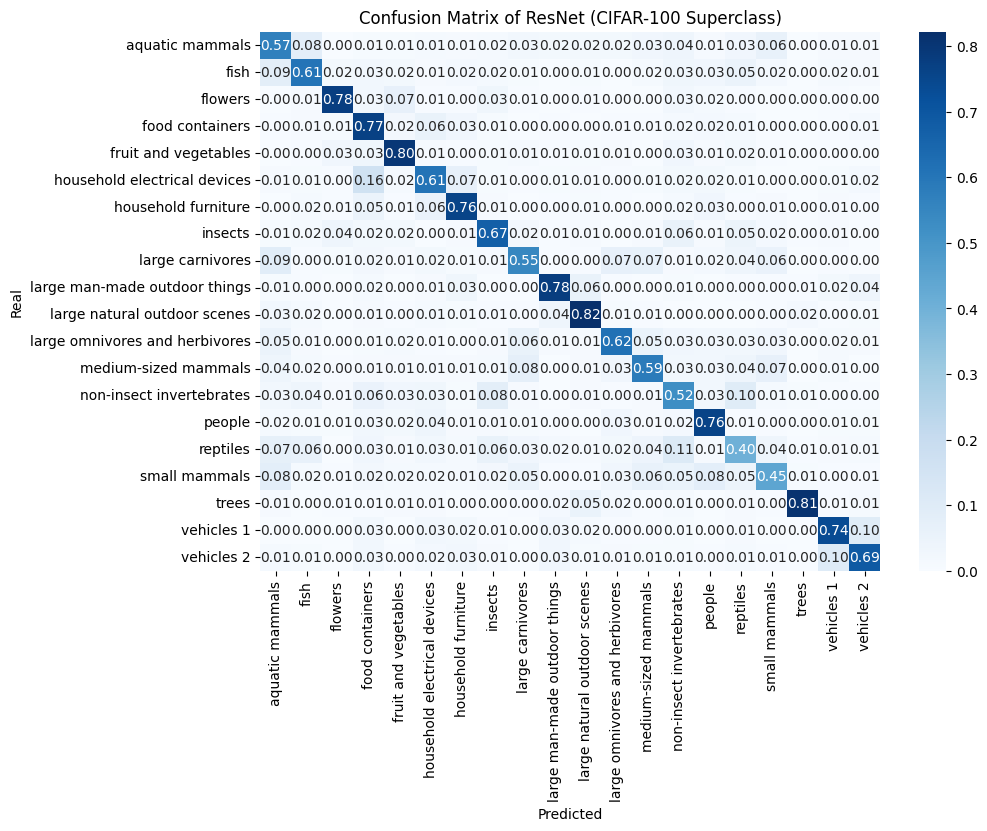

In [46]:
y_pred = []
y_true = []

# iterate over test data
for x, y in torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size):
    x = x.to(device)
    y = y.to(device)
    z = net(x)
    _, yhat = torch.max(z, 1)
    
    # Save Prediction and convert to superclasses
    pred = yhat.data.cpu().numpy()
    super_pred = [fine_to_superclass[p] for p in pred]
    y_pred.extend(super_pred)
    
    # Save Truth and convert to superclasses
    labels = y.data.cpu().numpy()
    super_labels = [fine_to_superclass[l] for l in labels]
    y_true.extend(super_labels)

# Build confusion matrix for superclasses
cf_matrix = confusion_matrix(y_true, y_pred, normalize='true')

# Normalize confusion matrix
df_cm = pd.DataFrame(cf_matrix, index=coarse_classes,
                     columns=coarse_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap='Blues')
plt.title('Confusion Matrix of ResNet (CIFAR-100 Superclass)')
plt.savefig('./runs/resnet_18/Confusion_matrix_ResNet_Cifar100_superclass.jpg')
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.show()

**Classification Report**

In [47]:
print(f"Super Classification Report of ResNet(CIFAR100)  \n { classification_report(y_true, y_pred)}")

Super Classification Report of ResNet(CIFAR100)  
               precision    recall  f1-score   support

           0       0.51      0.57      0.54       500
           1       0.64      0.61      0.62       500
           2       0.83      0.78      0.80       500
           3       0.56      0.77      0.65       500
           4       0.73      0.80      0.76       500
           5       0.61      0.61      0.61       500
           6       0.72      0.76      0.74       500
           7       0.67      0.67      0.67       500
           8       0.62      0.55      0.58       500
           9       0.79      0.78      0.78       500
          10       0.75      0.82      0.79       500
          11       0.69      0.62      0.65       500
          12       0.63      0.59      0.61       500
          13       0.50      0.52      0.51       500
          14       0.69      0.76      0.72       500
          15       0.46      0.40      0.43       500
          16       0.56      0